# Deel 1 : Productieproces

# A : nodige modules

In [1]:
# standaard in python
import os 
import datetime
import sys
import json

In [2]:
# te installeren packages en modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.stats import norm

import seaborn as sns

In [3]:
# eigen packages modules
current_working_directory = os.getcwd()                                    
parent_working_directory = os.path.dirname(current_working_directory)      
scripts_directory = os.path.join(parent_working_directory, 'scripts')      
sys.path.append(scripts_directory)                                         
# sys.path.remove(scripts_directory)
# print(sys.path)

import come_in_handy as cih
import model_simulatie as mdls
import model_data_loaders as mdll
import my_matplotlib_standards as mypltstd

In [4]:
# eigen standard set up uitvoering
mypltstd.my_matplotlib_pyplot_standards_setup()

# B : functies nog niet in modules

# C : opladen van de gegevens

In [5]:
# opladen JSON file met MSR waarden (min_sust_rate = minimu sustainable rate)
min_sust_rate_locatie = "../data/raw/productiemodel/data_productie/master_data.json"
df_msr_gegevens = mdll.laad_msr_gegevens_in_dataframe(min_sust_rate_locatie)

In [6]:
# bepaal waar de dagelijk productie sets (per fabriek) zich bevinden op schijf
dagelijkse_productie_locatie = "../data/raw/productiemodel/data_productie/daily_production/"

In [7]:
# Laad dagelijks productie voor BRU in BRU dataframe
factory = 'BRU'
dagelijkse_productie_BRU = mdll.laad_dagelijkse_productie_in_dataframe(
                                factory, 
                                os.path.join(dagelijkse_productie_locatie, factory))

# voeg MSR waarden toe op het BRU dagelijkse productie dataframe
dagelijkse_productie_BRU = dagelijkse_productie_BRU.merge(
                                        df_msr_gegevens, on='factory', how='left')

# verwijder records waar onderhoud werd gepland, zie opgave Deel 1, stap 5, bullet 1 en dixit Tim in de klas
dagelijkse_productie_BRU = dagelijkse_productie_BRU[dagelijkse_productie_BRU['maintenance'] == 'No']

In [8]:
# Laad dagelijks productie voor STO in STO dataframe
factory = 'STO'
dagelijkse_productie_STO = mdll.laad_dagelijkse_productie_in_dataframe(
                                factory, 
                                os.path.join(dagelijkse_productie_locatie, factory))

# voeg MSR waarden toe op het STO dagelijkse productie dataframe
dagelijkse_productie_STO = dagelijkse_productie_STO.merge(
                                        df_msr_gegevens, on='factory', how='left')

# verwijder records waar onderhoud werd gepland, zie opgave Deel 1, stap 5, bullet 1 en dixit Tim in de klas
dagelijkse_productie_STO = dagelijkse_productie_STO[dagelijkse_productie_STO['maintenance'] == 'No']

In [9]:
# Breng alle gegevens te samen in een groot dataframe, in geval van analyse totaal productie
dagelijkse_productie_ALL = pd.concat(
                            [dagelijkse_productie_BRU, 
                             dagelijkse_productie_STO],
                               ignore_index=True)

#  save het voor analyse in een Excel sheet, just in case
dagelijkse_productie_ALL.to_excel("../data/interim/dagelijkse_productie_ALL.xlsx")

# D : een eerste controle van de gegevens

In [10]:
# Allemaal in commentaar gezet, enkel interactief nodig

# dagelijkse_productie_BRU
# dagelijkse_productie_STO
# dagelijkse_productie_ALL

# dagelijkse_productie_BRU.describe()
# dagelijkse_productie_STO.describe()
# dagelijkse_productie_ALL.describe()

# dagelijkse_productie_BRU.describe(include = "all") 
# dagelijkse_productie_STO.describe(include = "all") 
# dagelijkse_productie_ALL.describe(include = "all") 

# dagelijkse_productie_BRU.info()
# dagelijkse_productie_STO.info()
# dagelijkse_productie_ALL.info()

In [11]:
#  bekijk structuur van de gegevens-set
print("Shape dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.shape)
print("Shape dagelijkse_productie_STO : ", dagelijkse_productie_STO.shape)
# print("Shape dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.shape)
print(len(dagelijkse_productie_BRU))

Shape dagelijkse_productie_BRU :  (1736, 11)
Shape dagelijkse_productie_STO :  (1716, 11)
1736


In [12]:
# bekijk of alle kolommen wel dezelfde zijn
print("Columns dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.columns)
print("Columns dagelijkse_productie_STO : ", dagelijkse_productie_STO.columns)
# print("Columns dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.columns)

Columns dagelijkse_productie_BRU :  Index(['DoW', 'hour', 'minute', 'date', 'maintenance', 'prod_loss',
       'prod_loss_perc', 'production', 'factory', 'msr_description',
       'msr_value'],
      dtype='object')
Columns dagelijkse_productie_STO :  Index(['DoW', 'hour', 'minute', 'date', 'maintenance', 'prod_loss',
       'prod_loss_perc', 'production', 'factory', 'msr_description',
       'msr_value'],
      dtype='object')


In [13]:
print("Index dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.index)
print("Index dagelijkse_productie_STO : ", dagelijkse_productie_STO.index)
# print("Index dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.index)

Index dagelijkse_productie_BRU :  Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829],
      dtype='int64', length=1736)
Index dagelijkse_productie_STO :  Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829],
      dtype='int64', length=1716)


# E : de kolom 'production' valideren en gebruiksklaar maken

In [14]:
#  Gaat allemaal over BRU
cih.show_info_about_column(dagelijkse_productie_BRU, 'production')

#  controle van de kolom production voor de BRU fabriek
missing_values = dagelijkse_productie_BRU['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_BRU['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production BRU", dagelijkse_productie_BRU['production'].mean())
# print(dagelijkse_productie_BRU['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production BRU", dagelijkse_productie_BRU['production'].median())
# print(dagelijkse_productie_BRU['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production BRU", dagelijkse_productie_BRU['production'].mode())
# print(dagelijkse_productie_BRU['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor BRU fabriek
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_BRU['production'] = dagelijkse_productie_BRU['production'].apply(pd.to_numeric)
dagelijkse_productie_BRU_zonder_productie = dagelijkse_productie_BRU[dagelijkse_productie_BRU['production'] == 0]
dagelijkse_productie_BRU_enkel_productie = dagelijkse_productie_BRU[dagelijkse_productie_BRU['production'] != 0]

print("Mean production BRU met enkel productie", dagelijkse_productie_BRU_enkel_productie['production'].mean())
print("Median production BRU met enkel productie", dagelijkse_productie_BRU_enkel_productie['production'].median())
print("Modus production BRU met enkel productie", dagelijkse_productie_BRU_enkel_productie['production'].mode())
print(f"----------------------------")


----- None -- production -----------------------------------
df[col].describe(include='all') = count     1736
unique     387
top          0
freq       308
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 387 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0       308
1011     13
1115     12
1005     11
1019     11
       ... 
869       1
886       1
874       1
418       1
876       1
Name: count, Length: 387, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 1736
----------------------------
Mean production BRU 813.7119815668203
Median production BRU 973.5
Modus production BRU 0    0
Name: production, dtype: object
----------------------------
Mean production BRU met enkel productie 989.218487394958
Median production BRU met enkel productie 1002.0
Modus production

In [15]:
cih.show_info_about_column(dagelijkse_productie_STO, 'production')

#  controle van de kolom production voor de BRU fabriek
missing_values = dagelijkse_productie_STO['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_STO['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production STO", dagelijkse_productie_STO['production'].mean())
# print(dagelijkse_productie_STO['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production STO", dagelijkse_productie_STO['production'].median())
# print(dagelijkse_productie_STO['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production STO", dagelijkse_productie_STO['production'].mode())
# print(dagelijkse_productie_STO['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor STO fabriek
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_STO['production'] = dagelijkse_productie_STO['production'].apply(pd.to_numeric)
dagelijkse_productie_STO_zonder_productie = dagelijkse_productie_STO[dagelijkse_productie_STO['production'] == 0]
dagelijkse_productie_STO_enkel_productie = dagelijkse_productie_STO[dagelijkse_productie_STO['production'] != 0]

print("Mean production STO met enkel productie", dagelijkse_productie_STO_enkel_productie['production'].mean())
print("Median production STO met enkel productie", dagelijkse_productie_STO_enkel_productie['production'].median())
print("Modus production STO met enkel productie", dagelijkse_productie_STO_enkel_productie['production'].mode())
print(f"----------------------------")


----- None -- production -----------------------------------
df[col].describe(include='all') = count     1716
unique     194
top          0
freq       126
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 194 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0      126
202     55
198     51
203     50
209     50
      ... 
110      1
34       1
145      1
41       1
152      1
Name: count, Length: 194, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 1716
----------------------------
Mean production STO 176.9458041958042
Median production STO 201.0
Modus production STO 0    0
Name: production, dtype: object
----------------------------
Mean production STO met enkel productie 190.9679245283019
Median production STO met enkel productie 202.0
Modus production STO met en

In [16]:
cih.show_info_about_column(dagelijkse_productie_ALL, 'production')

#  controle van de kolom production voor data set ALL (STO + BRU tesamen)
missing_values = dagelijkse_productie_ALL['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_ALL['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production ALL", dagelijkse_productie_ALL['production'].mean())
# print(dagelijkse_productie_ALL['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production ALL", dagelijkse_productie_ALL['production'].median())
# print(dagelijkse_productie_ALL['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production ALL", dagelijkse_productie_ALL['production'].mode())
# print(dagelijkse_productie_ALL['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor data set ALL ( STO + BRU tesamen)
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_ALL['production'] = dagelijkse_productie_ALL['production'].apply(pd.to_numeric)
dagelijkse_productie_ALL_zonder_productie = dagelijkse_productie_ALL[dagelijkse_productie_ALL['production'] == 0]
dagelijkse_productie_ALL_enkel_productie = dagelijkse_productie_ALL[dagelijkse_productie_ALL['production'] != 0]

print("Mean production ALL met enkel productie", dagelijkse_productie_ALL_enkel_productie['production'].mean())
print("Median production ALL met enkel productie", dagelijkse_productie_ALL_enkel_productie['production'].median())
print("Modus production ALL met enkel productie", dagelijkse_productie_ALL_enkel_productie['production'].mode())
print(f"----------------------------")

----- None -- production -----------------------------------
df[col].describe(include='all') = count     3452
unique     580
top          0
freq       434
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 580 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0      434
202     55
198     51
203     50
209     50
      ... 
474      1
630      1
642      1
896      1
152      1
Name: count, Length: 580, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 3452
----------------------------
Mean production ALL 497.17352259559675
Median production ALL 215.0
Modus production ALL 0    0
Name: production, dtype: object
----------------------------
Mean production ALL met enkel productie 568.668986083499
Median production ALL met enkel productie 224.5
Modus production ALL met en

# F : analyse van de mogelijke verdelingen

In [17]:
#  ingestelde paramaters 
days_to_simulate = 31
data_points_simulate = 1000

## F.1 : analyse productie data per fabriek

Kans op BRU productiedag zonder productie =  0.1774193548387097 


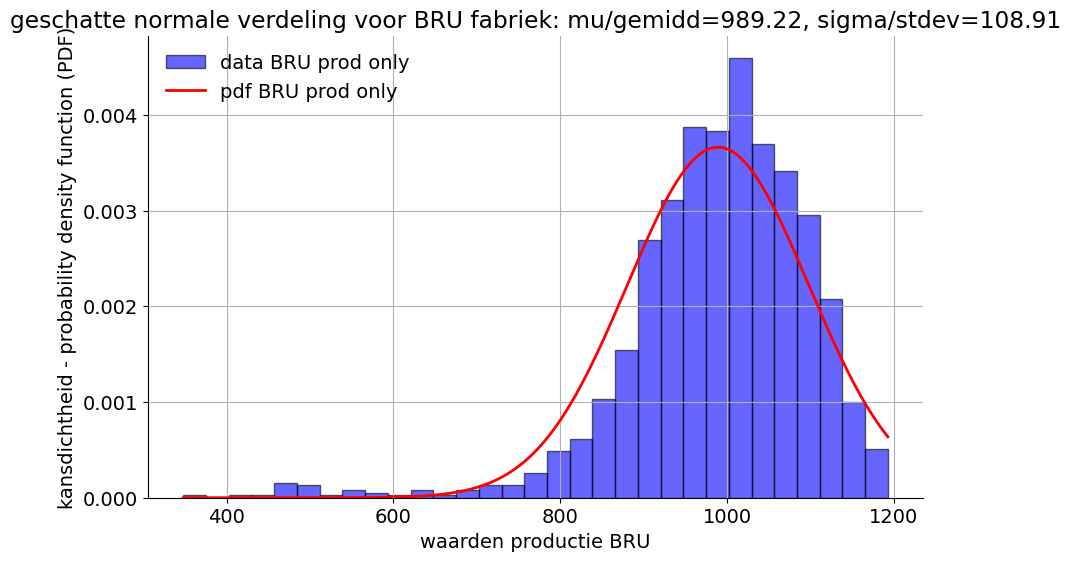

In [18]:
# analyse gegevens productie data voor BRU fabriek
p_zero_BRU =  len(dagelijkse_productie_BRU_zonder_productie) / len(dagelijkse_productie_BRU)
print(f"Kans op BRU productiedag zonder productie =  {p_zero_BRU} ")

# converteer naar array voor norm.fit
plotdata_BRU_enkel_productie = dagelijkse_productie_BRU_enkel_productie['production'].to_numpy()
mu_BRU, sigma_BRU = norm.fit(plotdata_BRU_enkel_productie)

# Maak een PDF (probability density function) op basis van de geschatte parameters
x_BRU = np.linspace(min(plotdata_BRU_enkel_productie), max(plotdata_BRU_enkel_productie), data_points_simulate)
pdf_BRU = norm.pdf(x_BRU, mu_BRU, sigma_BRU)

# Maak een histogram van de BRU productie gegevens
plt.hist(plotdata_BRU_enkel_productie, bins=days_to_simulate, density=True, alpha=0.6, color='blue', edgecolor='black', label='data BRU prod only')

# Plot de PDF
plt.plot(x_BRU, pdf_BRU, 'red', linewidth=2, label='pdf BRU prod only')

plt.title(f'geschatte normale verdeling voor BRU fabriek: mu/gemidd={mu_BRU:.2f}, sigma/stdev={sigma_BRU:.2f}')
plt.xlabel('waarden productie BRU')
plt.ylabel('kansdichtheid - probability density function (PDF)')
plt.grid(True)
plt.legend()
plt.show()

Kans op STO productiedag zonder productie =  0.07342657342657342 


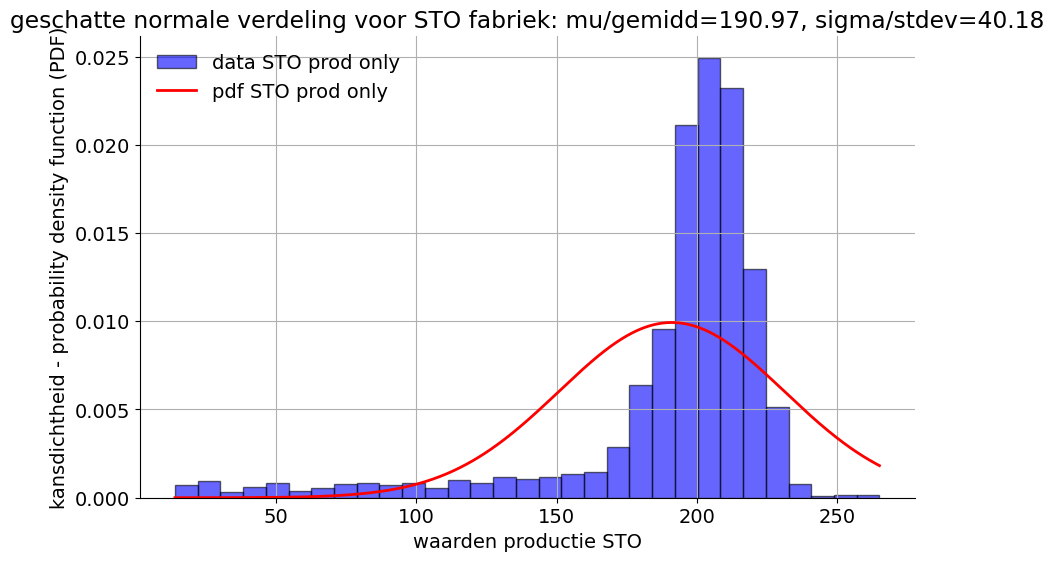

In [19]:
# analyse data voor STO fabriek
p_zero_STO = len(dagelijkse_productie_STO_zonder_productie) / len(dagelijkse_productie_STO) 
print(f"Kans op STO productiedag zonder productie =  {p_zero_STO} ")

# converteer naar array voor norm.fit
plotdata_STO_enkel_productie = dagelijkse_productie_STO_enkel_productie['production'].to_numpy()
mu_STO, sigma_STO = norm.fit(plotdata_STO_enkel_productie)

# Maak een PDF (probability density function) op basis van de geschatte parameters
x_STO = np.linspace(min(plotdata_STO_enkel_productie), max(plotdata_STO_enkel_productie), data_points_simulate)
pdf_STO = norm.pdf(x_STO, mu_STO, sigma_STO)

# Maak een histogram van de gegevens
plt.hist(plotdata_STO_enkel_productie, bins=days_to_simulate, density=True, alpha=0.6, color='blue', edgecolor='black', label='data STO prod only')

# Plot de PDF
plt.plot(x_STO, pdf_STO, 'red', linewidth=2, label='pdf STO prod only')

plt.title(f'geschatte normale verdeling voor STO fabriek: mu/gemidd={mu_STO:.2f}, sigma/stdev={sigma_STO:.2f}')
plt.xlabel('waarden productie STO')
plt.ylabel('kansdichtheid - probability density function (PDF)')
plt.grid(True)
plt.legend()
plt.show()

Kans op ALL productiedag zonder productie =  0.1257242178447277 


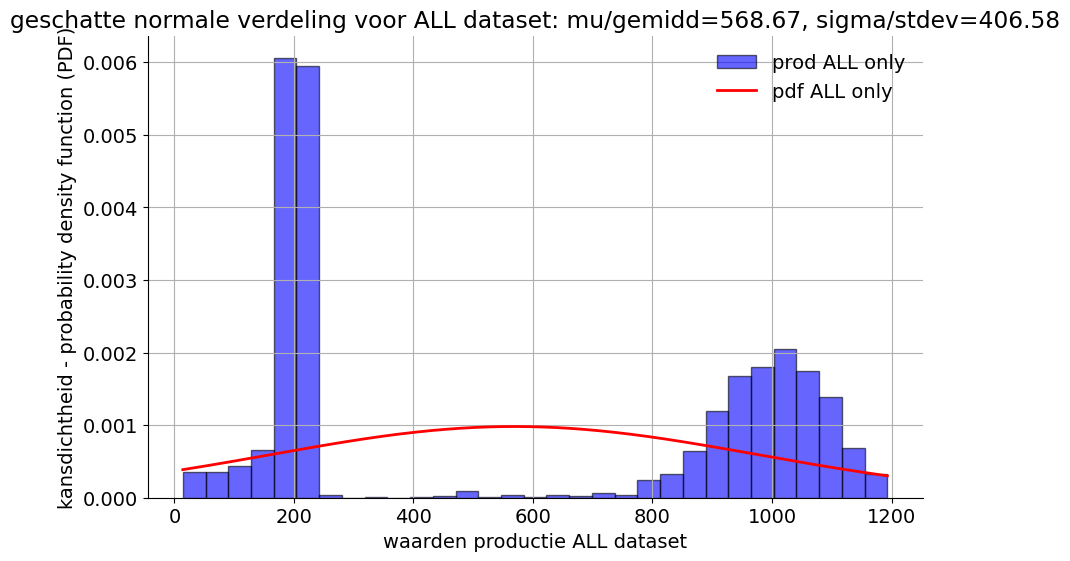

In [20]:
# analyse data voor ALL dataset (STO + BRU tesamen)
p_zero_ALL = len(dagelijkse_productie_ALL_zonder_productie) / len(dagelijkse_productie_ALL)
print(f"Kans op ALL productiedag zonder productie =  {p_zero_ALL} ")

plotdata_ALL_enkel_productie = dagelijkse_productie_ALL_enkel_productie['production'].to_numpy()
mu_ALL, sigma_ALL = norm.fit(plotdata_ALL_enkel_productie)

# Maak een histogram van de gegevens
plt.hist(plotdata_ALL_enkel_productie, bins=days_to_simulate, density=True, alpha=0.6, color='blue', edgecolor='black', label='prod ALL only')

# Maak een PDF (probability density function) op basis van de geschatte parameters
x_ALL = np.linspace(min(plotdata_ALL_enkel_productie), max(plotdata_ALL_enkel_productie), data_points_simulate)
pdf_ALL = norm.pdf(x_ALL, mu_ALL, sigma_ALL)

# Plot de PDF
plt.plot(x_ALL, pdf_ALL, 'red', linewidth=2, label='pdf ALL only')
plt.title(f'geschatte normale verdeling voor ALL dataset: mu/gemidd={mu_ALL:.2f}, sigma/stdev={sigma_ALL:.2f}')
plt.xlabel('waarden productie ALL dataset')
plt.ylabel('kansdichtheid - probability density function (PDF)')
plt.grid(True)
plt.legend()
plt.show()

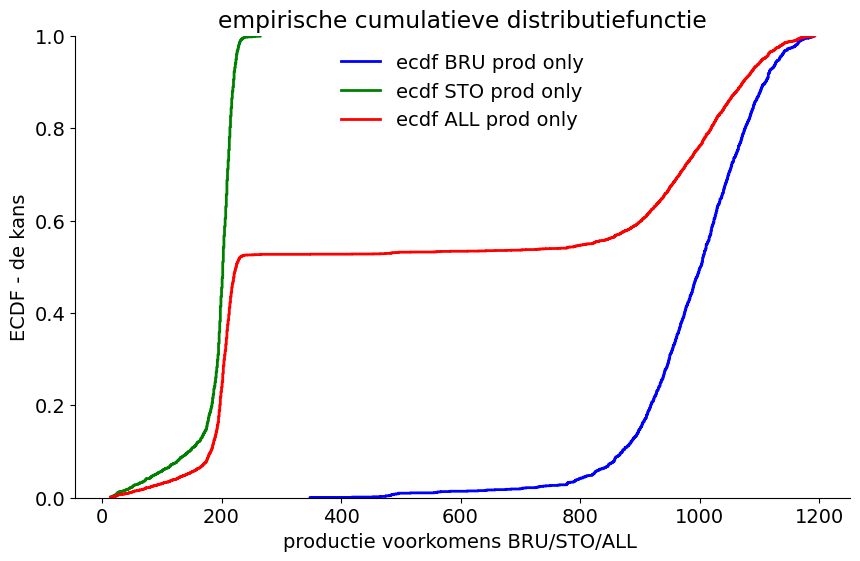

In [21]:
sns.ecdfplot(data=dagelijkse_productie_BRU_enkel_productie, x='production', color='b', linewidth=2, label='ecdf BRU prod only')
sns.ecdfplot(data=dagelijkse_productie_STO_enkel_productie, x='production', color='g', linewidth=2, label='ecdf STO prod only')
sns.ecdfplot(data=dagelijkse_productie_ALL_enkel_productie, x='production', color='r', linewidth=2, label='ecdf ALL prod only')

plt.xlabel('productie voorkomens BRU/STO/ALL ')
plt.ylabel('ECDF - de kans')
plt.title('empirische cumulatieve distributiefunctie')

plt.legend()
plt.show()

## F.2 : analyse hoe te simuleren per fabriek

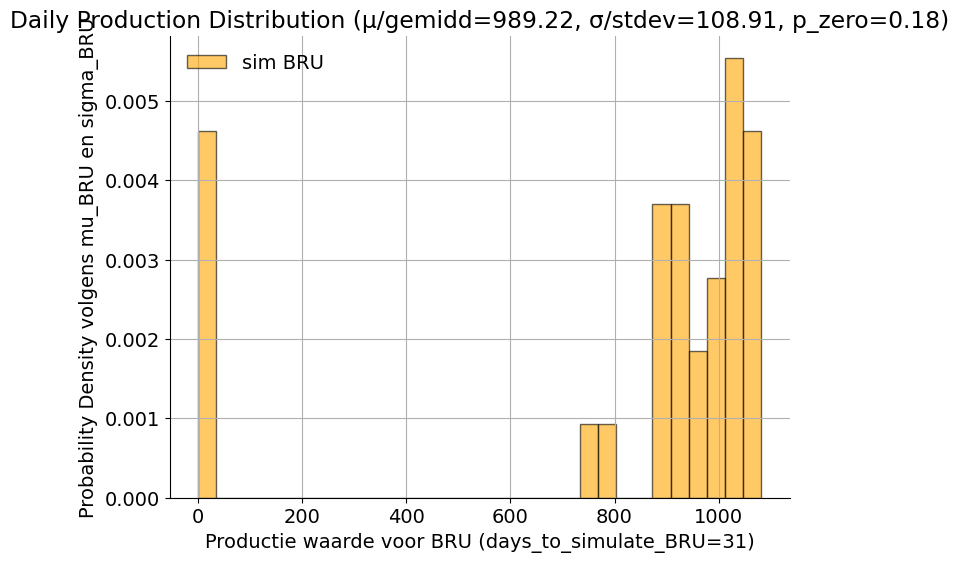

In [22]:
#  Alles enkel van toepassing voor BRU
days_to_simulate_BRU = days_to_simulate

#  integratie van kans op nul productie komt van CHatGPT, ik zou er zelf nooit opgekomen zijn
#  daarvoor ken ik veel te weinig van kansberekening an sich
#  opletten met dat random verhaal, seed() gebruken, vragen aan Tim
zero_production_BRU_simulated = np.zeros(int(p_zero_BRU * days_to_simulate_BRU))
positive_production_BRU_simulated = np.random.normal(mu_BRU, sigma_BRU, days_to_simulate_BRU - len(zero_production_BRU_simulated))
daily_production_BRU_simulated = np.concatenate((zero_production_BRU_simulated, positive_production_BRU_simulated))
daily_production_BRU_integer_simulated = np.round(daily_production_BRU_simulated).astype(int)

# Plot de simulatie
plt.figure(figsize=(8, 6))
plt.hist(daily_production_BRU_integer_simulated, bins=days_to_simulate_BRU, density=True, alpha=0.6, color='orange', edgecolor='black', label='sim BRU')
plt.xlabel(f'Productie waarde voor BRU (days_to_simulate_BRU={days_to_simulate_BRU})')
plt.ylabel('Probability Density volgens mu_BRU en sigma_BRU')
plt.title(f'Daily Production Distribution (μ/gemidd={mu_BRU:.2f}, σ/stdev={sigma_BRU:.2f}, p_zero={p_zero_BRU:.2f})')
plt.grid(True)
plt.legend()
plt.show()

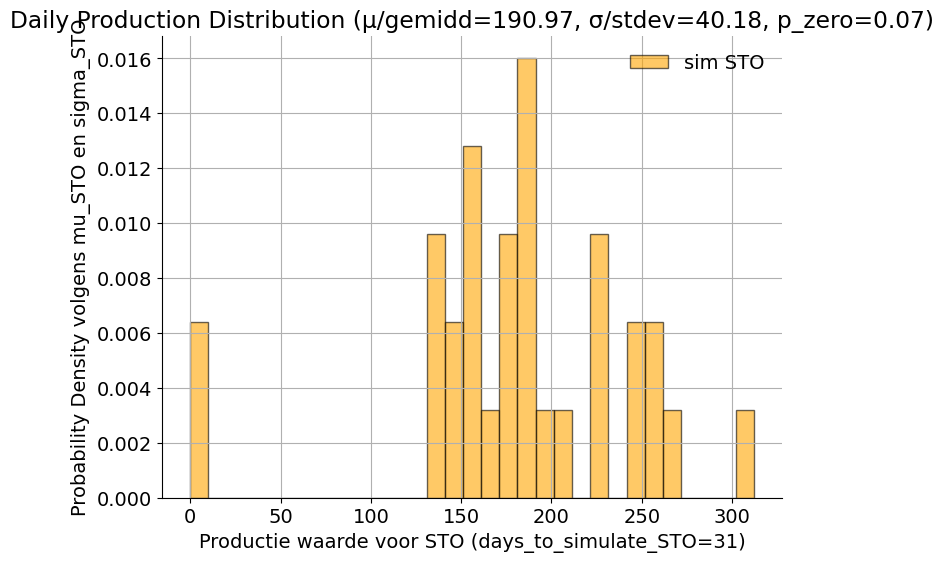

In [23]:
#  Alles enkel van toepassing voor STO
days_to_simulate_STO = days_to_simulate

#  integratie van kans op nul productie komt van CHatGPT, ik zou er zelf nooit opgekomen zijn
#  daarvoor ken ik veel te weinig van kansberekening an sich
#  opletten met dat random verhaal, seed() gebruken, vragen aan Tim
zero_production_STO_simulated = np.zeros(int(p_zero_STO * days_to_simulate_STO))
positive_production_STO_simulated = np.random.normal(mu_STO, sigma_STO, days_to_simulate_STO - len(zero_production_STO_simulated))
daily_production_STO_simulated = np.concatenate((zero_production_STO_simulated, positive_production_STO_simulated))
daily_production_STO_integer_simulated = np.round(daily_production_STO_simulated).astype(int)

# Plot de simulatie
plt.figure(figsize=(8, 6))
plt.hist(daily_production_STO_integer_simulated, bins=days_to_simulate_STO, density=True, alpha=0.6, color='orange', edgecolor='black', label='sim STO')
plt.xlabel(f'Productie waarde voor STO (days_to_simulate_STO={days_to_simulate_STO})')
plt.ylabel('Probability Density volgens mu_STO en sigma_STO')
plt.title(f'Daily Production Distribution (μ/gemidd={mu_STO:.2f}, σ/stdev={sigma_STO:.2f}, p_zero={p_zero_STO:.2f})')
plt.grid(True)
plt.legend()
plt.show()

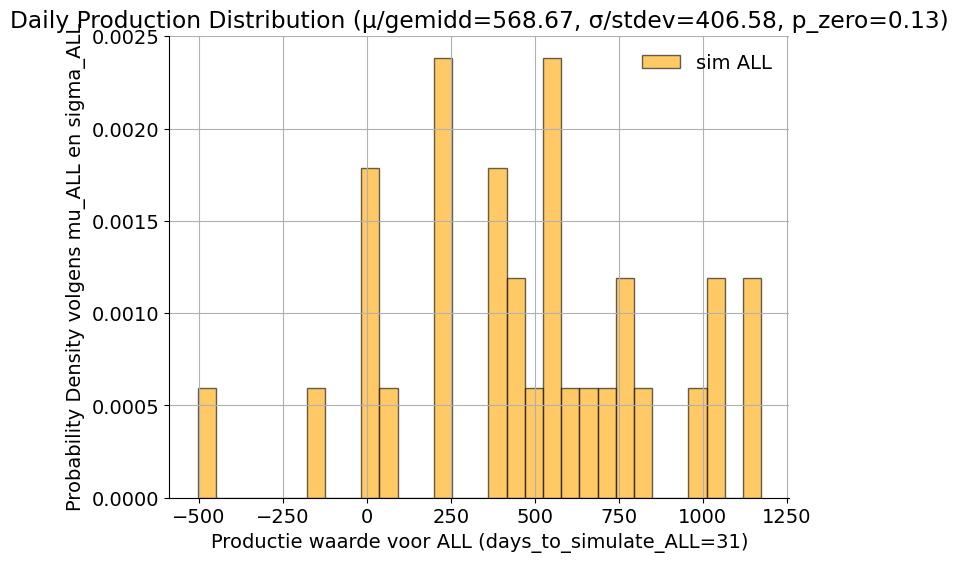

In [24]:
#  Alles enkel van toepassing voor ALL
days_to_simulate_ALL = days_to_simulate

#  integratie van kans op nul productie komt van CHatGPT, ik zou er zelf nooit opgekomen zijn
#  daarvoor ken ik veel te weinig van kansberekening an sich
#  opletten met dat random verhaal, seed() gebruken, vragen aan Tim
zero_production_ALL_simulated = np.zeros(int(p_zero_ALL * days_to_simulate_ALL))
positive_production_ALL_simulated = np.random.normal(mu_ALL, sigma_ALL, days_to_simulate_ALL - len(zero_production_ALL_simulated))
daily_production_ALL_simulated = np.concatenate((zero_production_ALL_simulated, positive_production_ALL_simulated))
daily_production_ALL_integer_simulated = np.round(daily_production_ALL_simulated).astype(int)

# --------------------------------------------------------------------------------
# WOW ... blijkbaar kan ik hier met deze gegevens NEGATIEVE productie genereren !!
# Wat is het probleem met positive_production_ALL_simulated ??? 
# Vermoedelijk iets te maken met het gemiddelde en de stdev zeker ? 
# --------------------------------------------------------------------------------

# Plot de simulatie
plt.figure(figsize=(8, 6))
plt.hist(daily_production_ALL_integer_simulated, bins=days_to_simulate_ALL, density=True, alpha=0.6, color='orange', edgecolor='black', label='sim ALL')
plt.xlabel(f'Productie waarde voor ALL (days_to_simulate_ALL={days_to_simulate_ALL})')
plt.ylabel('Probability Density volgens mu_ALL en sigma_ALL')
plt.title(f'Daily Production Distribution (μ/gemidd={mu_ALL:.2f}, σ/stdev={sigma_ALL:.2f}, p_zero={p_zero_ALL:.2f})')
plt.grid(True)
plt.legend()
plt.show()

# G : uitvoeren van de simulatie (oplossing)

In [29]:
# Empty on purpose, in case of changes to mdls.simulatie()
mdls.simulatie?

Signature:
mdls.simulatie(
    days_to_simulate,
    data_points,
    dagelijkse_productie,
    use_random_seed,
)
Docstring:
What:
    function will take production numbers (zero and non-zero)
    for a factory and will 
    calculate the chance p_zero 

Args:
    days_to_simulate : integer, obligated
            requested number of days to simulate
    data_points : integer, obligated
            used number of linspace intervals to draw the PDF function 
            for given dagelijke_productie parameter
    dagelijkse_productie : ndarray, obligated
            in this exercise the column ['production'] from given dataset
    use_random_seed : string, obligated
            any value <> 'random' will not set the seed value for np.linspace
    
Returns:
    plotdata_enkel_productie : ndarray 
        plot data with non-zero values only to be used for 
        histogram live production data
        against computed simulation plot data
    x : ndarray
        evaluation base fr pdf
  

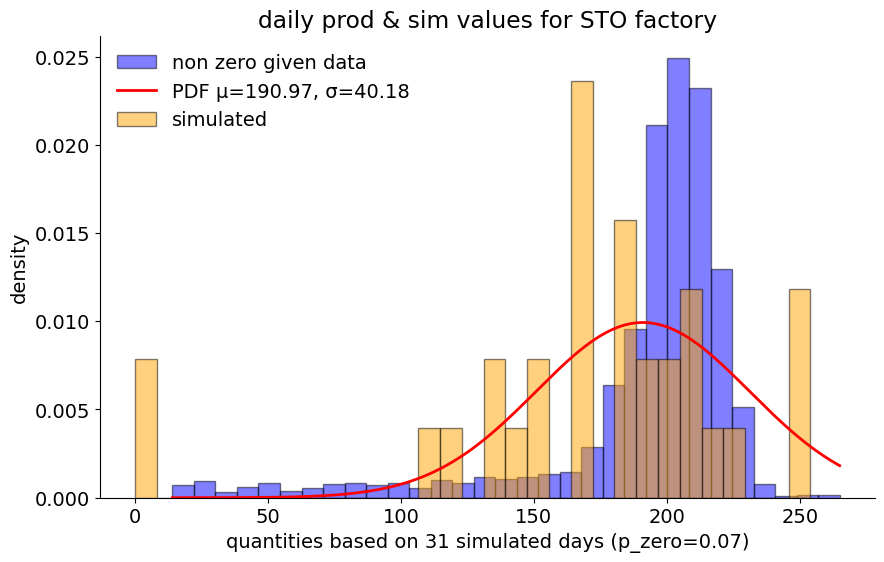

In [26]:
# input parameters
days_to_simulate = 31
data_points_simulate = 1000
use_random_seed = 'not random'  # value 'random' will provoke randomness, other values will use constant seed value 42

# use 'BRU', 'STO' of 'ALL'
# fabriek = 'BRU'  
fabriek = 'STO'  
# fabriek = 'ALL'  

# use dagelijkse_productie_{xxx} where xxx = 'BRU', 'STO' of 'ALL'
# productiegegevens = dagelijkse_productie_BRU['production']
productiegegevens = dagelijkse_productie_STO['production']
# productiegegevens = dagelijkse_productie_ALL['production']

# de simulatie die de nodige gegevens teruggeeft om te plotten
#  productie gegevens is de productiekolom van de productie gegevens van de fabriek
(plotdata_enkel_productie, 
 x, 
 pdf,
 plotdata_simulatie,
 mu,
 sigma,
 p_zero) = (mdls.simulatie(days_to_simulate, 
                          data_points_simulate, 
                          productiegegevens,
                          use_random_seed
                          )
            )

# Maak een histogram van de originele productie gegevens, zonder dagen waar géén productie was
plt.hist(plotdata_enkel_productie, bins=days_to_simulate, density=True, alpha=0.5, color='blue', edgecolor='black', label='non zero given data')

# Plot de PDF op basis van de mu & sigma onttrokken aan de originele productiegegevens (zonder znul dag production)
plt.plot(x, pdf, 'red', linewidth=2, label=f'PDF µ={mu:.2f}, σ={sigma:.2f}')

# Plot de simulatie voor gevraagde aantal dagen, inclusief de geschatte nul dag productie
plt.hist(plotdata_simulatie, bins=days_to_simulate, density=True, alpha=0.5, color='orange', edgecolor='black', label='simulated')
plt.xlabel(f'quantities based on {days_to_simulate} simulated days (p_zero={p_zero:.2f})')
plt.ylabel(f'density')
plt.title(f'daily prod & sim values for {fabriek} factory')
plt.legend()
plt.show()

# Z : losse ideeën over wat kans dan wel is ... kladwerk etc.

The probability of observing a production quantity less than or equal to 250 is 0.5714285714285714
The probability of observing a production quantity less than or equal to 150 is 0.2857142857142857
The probability of observing a production quantity less than or equal to 100 is 0.14285714285714285
The probability of observing a production quantity less than or equal to 225 is 0.42857142857142855
The probability of observing a production quantity less than or equal to 300 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 305 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 349 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 350 is 0.8571428571428571
The probability of observing a production quantity less than or equal to 400 is 1.0
The probability of observing a production quantity less than or equal to 475 is 1.0


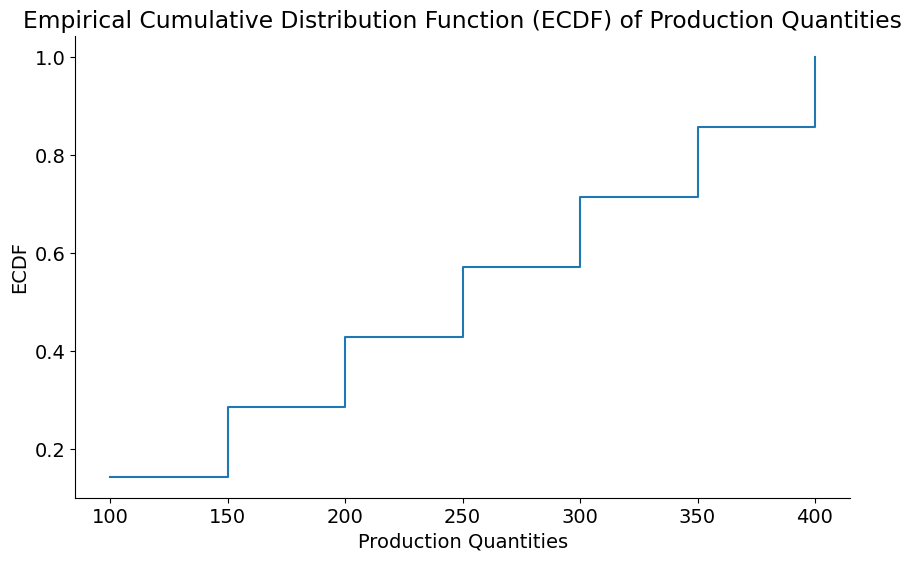

In [27]:
# Sample data: production quantities over a number of days
production_quantities = np.array([100, 150, 200, 250, 300, 350, 400])

# Calculate the ECDF
x = np.sort(production_quantities)
y = np.arange(1, len(x)+1) / len(x)

# Function to evaluate the ECDF at a given point
def ecdf(value):
    return y[x <= value].max()

# Predict the probability of a value
value = 250
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 150
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 100
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 225
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 300
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 305
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 349
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 350
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 400
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 475
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")


# Plot the ECDF
plt.step(x, y, where='post')
plt.xlabel('Production Quantities')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF) of Production Quantities')
plt.show()